In [2]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np
from functools import partial
from scipy.optimize import minimize

import torch
import torch.optim as optim

from nflows.flows import MaskedAutoregressiveFlow

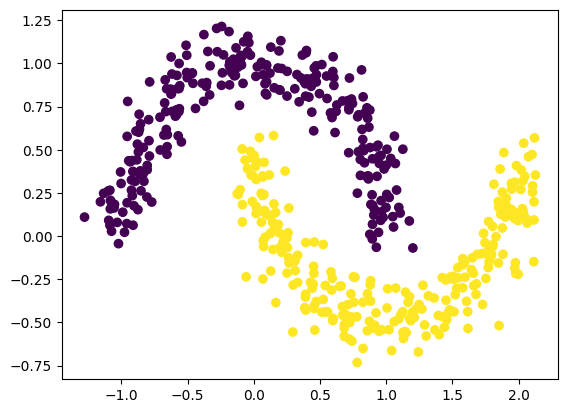

In [3]:
x, y = datasets.make_moons(512, noise=0.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [4]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
optimizer = optim.Adam(flow.parameters())

In [5]:
num_iter = 3000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    if (i + 1) % 500 == 0:
        print(loss.item())

0.8247812986373901
0.4497051239013672
0.4077942967414856
0.42949071526527405
0.3842616677284241
0.3913414776325226


In [38]:
y_0 = torch.Tensor([[0.0]])
y_1 = torch.Tensor([[1.0]])
# x = [0.7,  0.01]
x = [1.,  0.]

def optim_f(x_hat, x_i, model, y_orig, y_hat, alpha=1.0):
    with torch.no_grad():
        x_i = torch.Tensor([x_i])
        x_hat = torch.Tensor([x_hat])
        p_orig = model.log_prob(x_hat, context=y_orig).detach().item()
        p_hat = model.log_prob(x_hat, context=y_hat).detach().item()
        dist = np.linalg.norm(x_i-x_hat)
        return - alpha*p_hat + dist

res = minimize(optim_f, x, method="Nelder-Mead", args=(x, flow, y_0, y_1, 0.5))
res.x

array([ 0.61897017, -0.4210587 ])

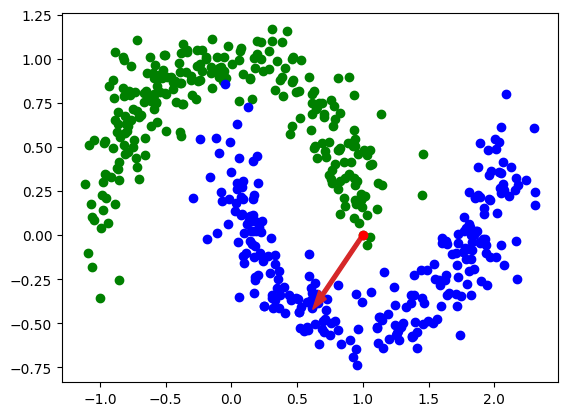

In [39]:
with torch.no_grad():
    samples_zero, log_probs = flow.sample_and_log_prob(256, context=torch.Tensor([[0]]))
    samples_one, log_probs = flow.sample_and_log_prob(256, context=torch.ones(1, 1))
plt.scatter(samples_zero.squeeze()[:, 0], samples_zero.squeeze()[:, 1], c="g")
plt.scatter(samples_one.squeeze()[:, 0], samples_one.squeeze()[:, 1], c="b")
plt.arrow(x[0], x[1], res.x[0]-x[0], res.x[1]-x[1], width=0.025, length_includes_head=True, color="C3")
plt.scatter(x[0], x[1], c="r")

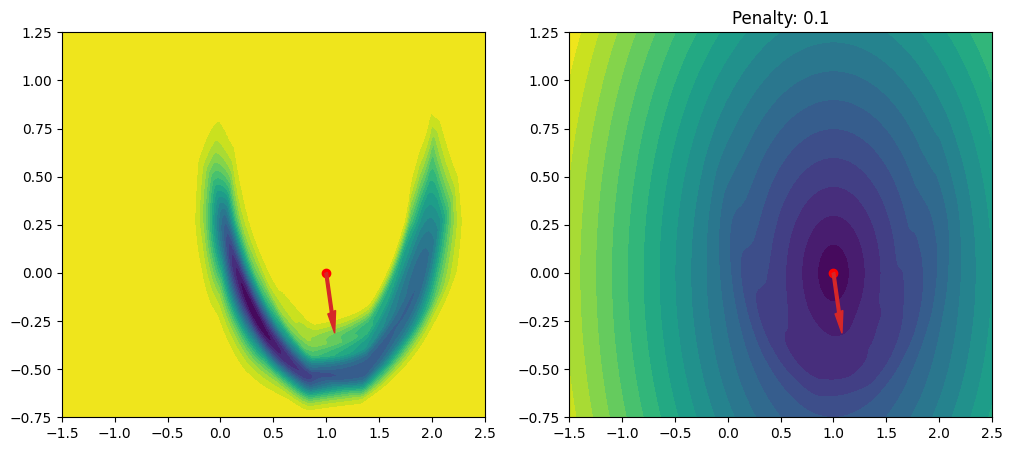

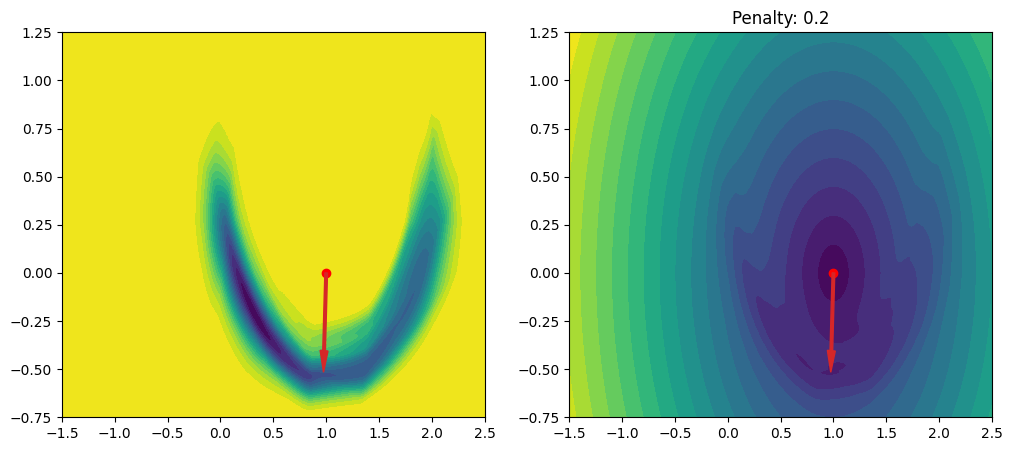

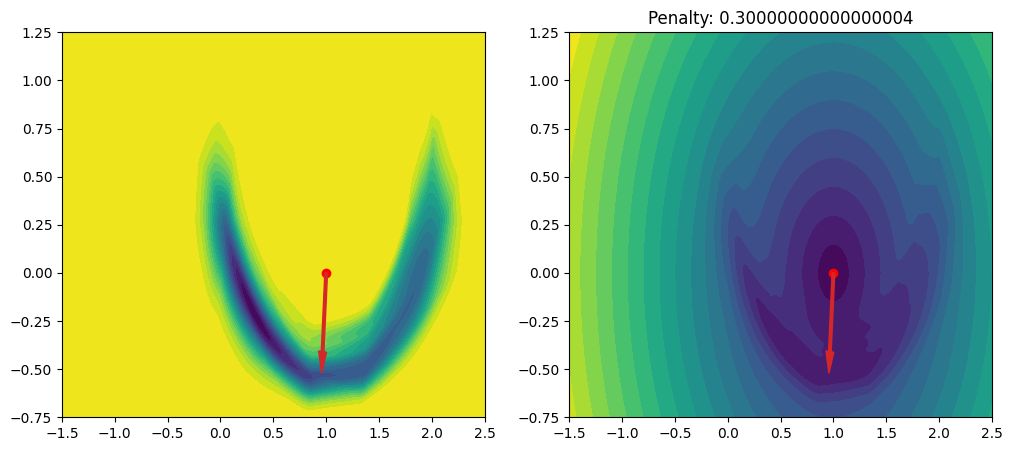

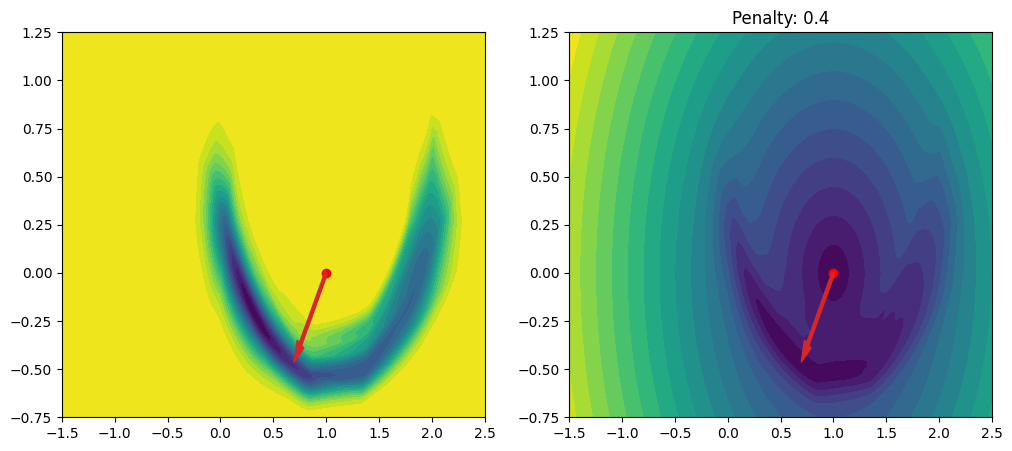

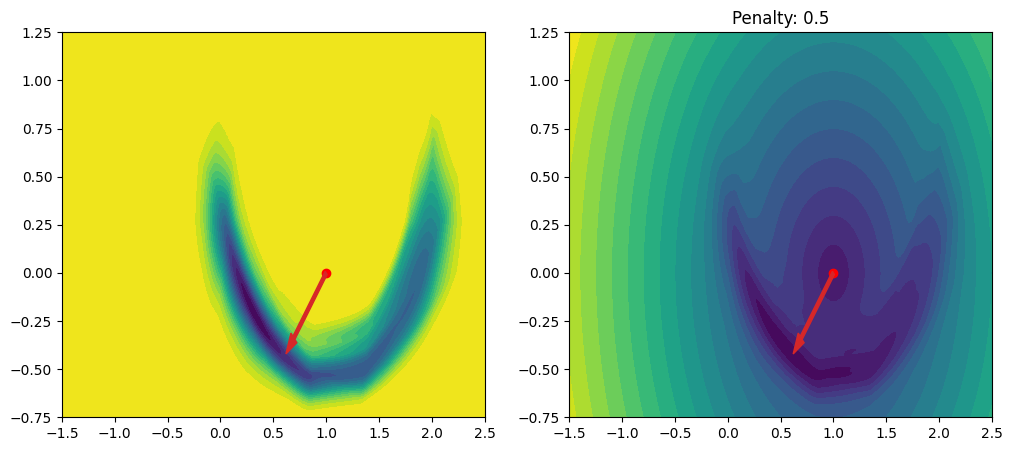

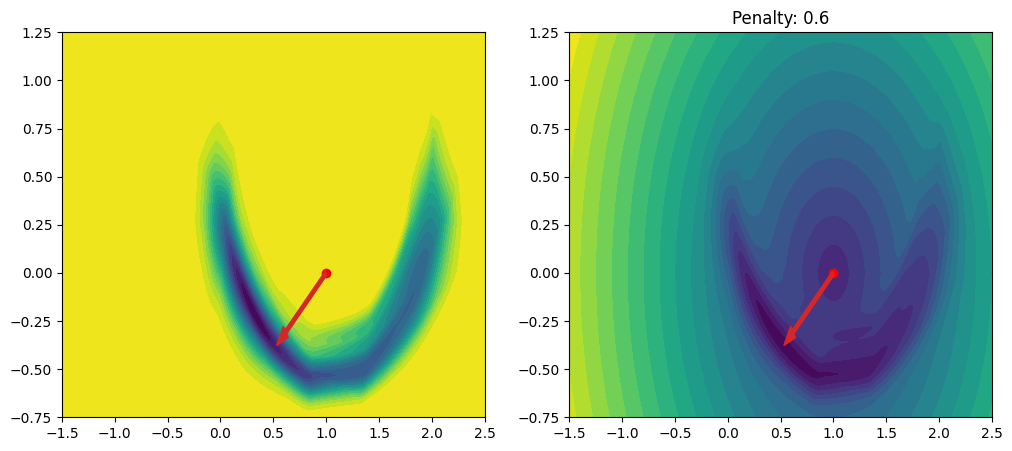

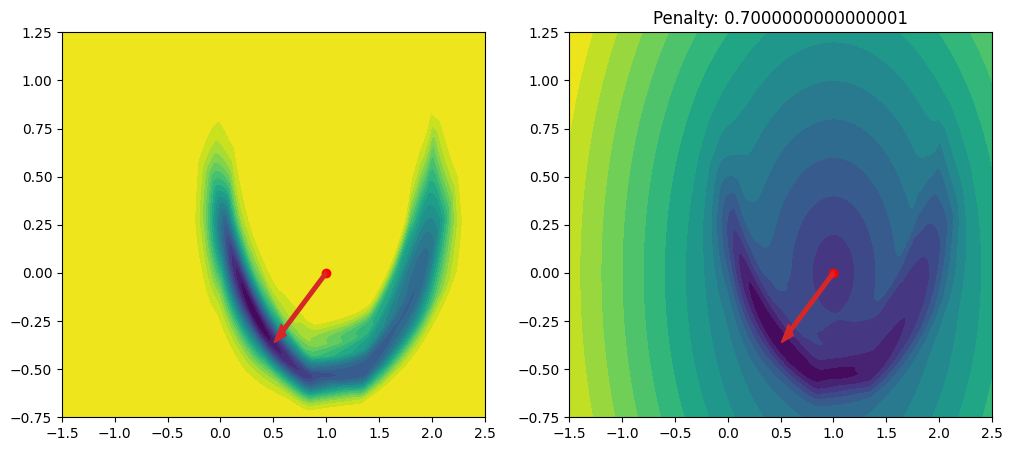

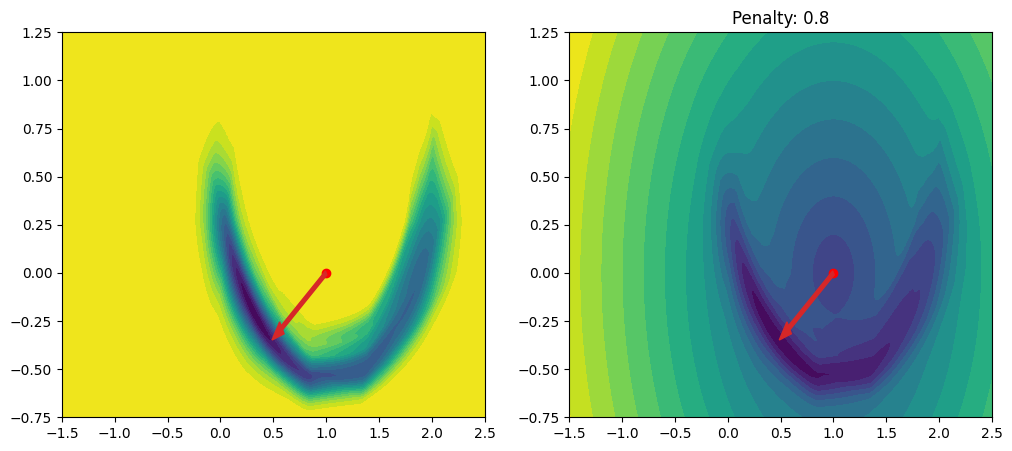

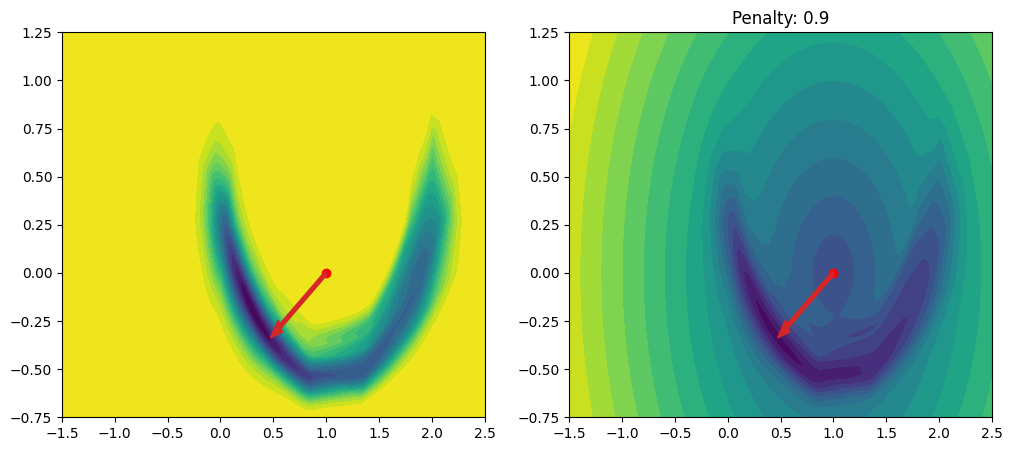

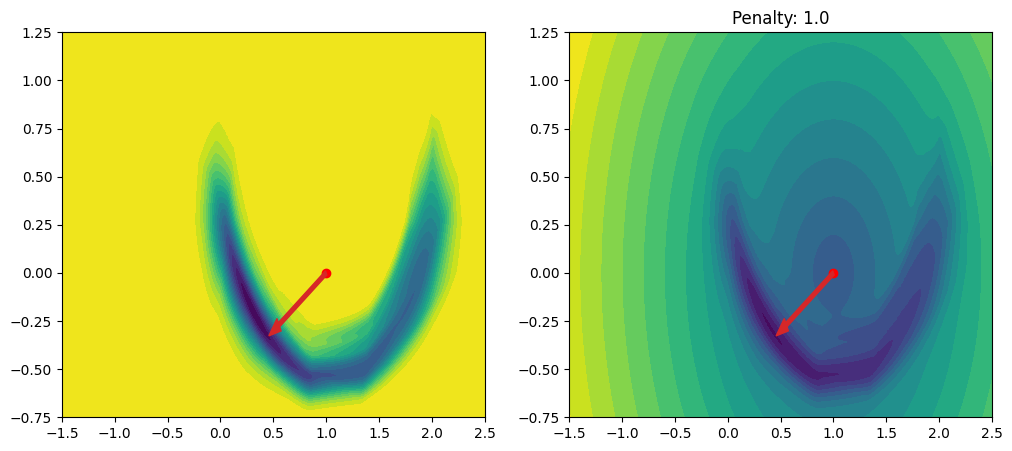

In [40]:
x_init = torch.Tensor([x])
xline = torch.linspace(-1.5, 2.5, 200)
yline = torch.linspace(-.75, 1.25, 200)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for i in np.linspace(0.1, 1, 10):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12,5)

    with torch.no_grad():
        zgrid0 = - flow.log_prob(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200)
        zgrid1 = - i*flow.log_prob(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200) + np.linalg.norm(xyinput-x_init.repeat(40000, 1), axis=1).reshape(200, 200)

    ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy(), levels=20)
    ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy(), levels=20)
    ax[0].scatter(x_init[0,0], x_init[0,1], c="r")
    ax[1].scatter(x_init[0,0], x_init[0,1], c="r")

    res = minimize(optim_f, x, method="Nelder-Mead", args=(x, flow, y_0, y_1, i))
    ax[0].arrow(x[0], x[1], res.x[0]-x[0], res.x[1]-x[1], width=0.025, length_includes_head=True, color="C3")
    ax[1].arrow(x[0], x[1], res.x[0]-x[0], res.x[1]-x[1], width=0.025, length_includes_head=True, color="C3")
    plt.title(f"Penalty: {i}")
    plt.show()